# **AutoEncoders**
Autoencoders are used to reduce the dimensions i.e. extarct information and store it in a deeper latent space and then build back this condensed information backup. No variation is used in this model. The word Auto comes from self the model self learns features and also learns to reduce these features into a smaller latent space, this process is called encoding threfore the blocks are called AutoEncoders.

* Loss function used is the MSE of the generated image and the original image, minimizing this gives us the exact image, without all the noise and clearer better image. 

Autoencoders achieve this by using using two main blocks,
1. One block to reduce the dimensions into a smaller mre condensed form, called the ***Encoder***.
2. The other block recontructs this condensed information back up, called the ***Decoder***.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class AutoEncoderBlock(nn.Module):
    def __init__(self, image_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2,padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out_image = self.decoder(latent)
        return out_image



The current architecture used is for the 

(450, 800, 3)
3


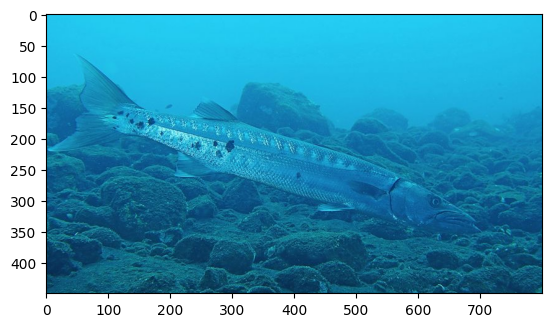

In [2]:
import cv2

img = plt.imread("/kaggle/input/private-1/archive-3/Train/Raw/100_img_.png")
plt.imshow(img)
print(img.shape)

image_channels = img.shape[-1]
print(image_channels) #Input channels are 3

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Had to decrease BATCH size and model architecure to get it trained on this.

In [4]:
import torch.optim as optim
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

model = AutoEncoderBlock(image_channels).to(device) 

loss_f = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

data_path = "/kaggle/input/private-1/archive-3/Train/Raw"


# max_height = 0
# max_width = 0
# for image in os.listdir(data_path):
#     img = plt.imread(os.path.join(data_path, image))
#     height, width = img.shape[:2]
#     max_height = max(max_height, height)
#     max_width = max(max_width, width)

class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        image = plt.imread(image_path)
        image = self.transform(image)
        image = image.to(device) 
        return image
#         if ret_tens.dim() == 3 and ret_tens.shape[2] == 1:  # If there's a single channel
#             ret_tens = ret_tens.squeeze(2)  # Squeeze channel dimension
# print(max_height," ",max_width)
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((max_height, max_width)),  # Resize to max dimensions
#     transforms.Pad((0, 0, max_width - max_height, 0), padding_mode='constant'),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
# ])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((1000, 2000)),  # Resize to max dimensions
#     transforms.Pad((0, 0, max_width - max_height, 0), padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=1, shuffle=True)

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image in X:
        optimizer.zero_grad()
        output_img = model(image)
        loss = loss_f(image, output_img)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/10], Loss: {total_loss / len(X):.4f}')
        

Epoch [1/10], Loss: 0.2417
Epoch [2/10], Loss: 0.1966
Epoch [3/10], Loss: 0.1935
Epoch [4/10], Loss: 0.1920
Epoch [5/10], Loss: 0.1909
Epoch [6/10], Loss: 0.1904
Epoch [7/10], Loss: 0.1902
Epoch [8/10], Loss: 0.1894
Epoch [9/10], Loss: 0.1893
Epoch [10/10], Loss: 0.1888


In [5]:
# Save the model
torch.save(model.state_dict(), "autoencoder_model.pth")

In [6]:
# Load the model
model = AutoEncoderBlock(image_channels).to(device)
model.load_state_dict(torch.load("autoencoder_model.pth"))
model.eval()

/tmp/ipykernel_1132/3628275451.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_model.pth"))


AutoEncoderBlock(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

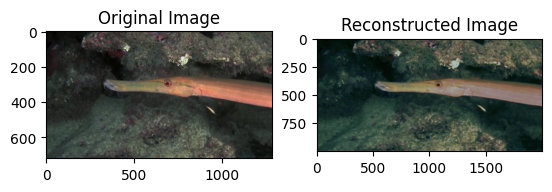

In [7]:
from PIL import Image
def process_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((1000, 2000)),
        transforms.ToTensor(),  # Convert image to tensor [C, H, W]
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor

input_image_path = "/kaggle/input/private-1/archive-3/Train/Raw/12336.png"
input_img = process_image(input_image_path)

with torch.no_grad():
    reconstructed_img = model(input_img)
reconstructed_img = reconstructed_img.squeeze(0).cpu()
reconstructed_img = reconstructed_img.permute(1, 2, 0).numpy()  # Change to [H, W, C] for visualization

# Plot original and reconstructed images
plt.subplot(1, 2, 1)
plt.title("Original Image")
original_img = Image.open(input_image_path)
plt.imshow(original_img)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img)
plt.show()

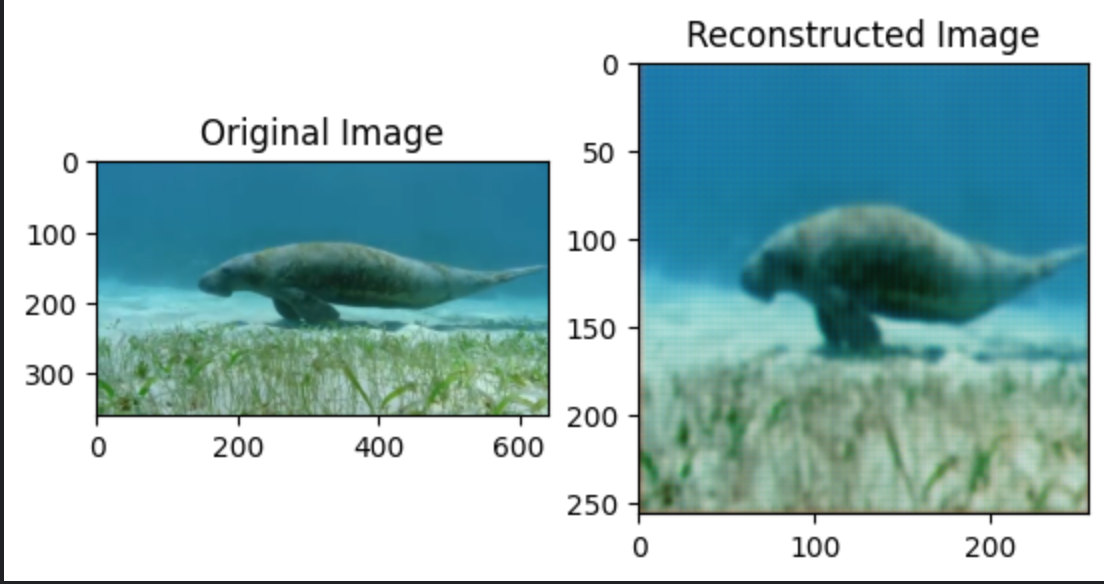


# Variational AutoEncoders

Variational Autoencoders are the evolution of the autoencoders, autoencoders are usually used for denoising images and enchancing, typically used as a smaller part of a bigger model mainly used to learn features from the input and reduce the dimensionality of the input, Variational Autoencoders (VAE) take this concept further by adding a probabilistic element, enabling the model to learn a distribution over the latent space. Unlike traditional autoencoders, which map inputs to a single deterministic point in the latent space, VAEs map them to a Gaussian distribution. This allows for the generation of new data by sampling from the learned distribution.

In [2]:
import torch
import torch.nn as nn

In [4]:
class VAE(nn.Module):
    def __init__(self, image_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2,padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.input_dim = 250 * 375 * 16
        self.latent_space = 250 * 375 * 16
        
        self.mu = nn.Linear(self.input_dim, self.latent_space)
        self.sigma = nn.Linear(self.input_dim, self.latent_space)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        
        mu = self.mu(x)
        logvar = self.sigma(x)
        
        z = reparam(mu, logvar)
        
        z = z.view(-1, 16, 250, 500)
        out_image = self.decoder(z)
        return out_image, mu, logvar
    
    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        

In [5]:
mse = nn.MSELoss()

def loss_f(out, inp, mu, logvar):
    mse = mse(out, inp)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return mse + kl_div

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_channels = 3
device
# Has to be cuda

device(type='cuda')

In [7]:
!nvidia-smi 

Mon Oct  7 13:17:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch.optim as optim
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

model = VAE(image_channels).to(device) 

optimizer = optim.Adam(model.parameters(), lr=1e-3)

data_path = "/kaggle/input/private-1/archive-3/Train/Raw"

class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        image = plt.imread(image_path)
        image = self.transform(image)
        image = image.to(device) 
        return image
    
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((1000, 1500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5) 
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=1, shuffle=True)

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for image in X:
        optimizer.zero_grad()
        output_img = model(image)
        loss = loss_f(image, output_img)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/10], Loss: {total_loss / len(X):.4f}')
        

In [ ]:
torch.save(model.state_dict(), "vae1.pth")

In [ ]:
model = VAE(image_channels).to(device)
model.load_state_dict(torch.load("vae1.pth"))
model.eval()  

In [ ]:
from PIL import Image
def process_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((1000, 2000)),
        transforms.ToTensor(),  # Convert image to tensor [C, H, W]
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor

input_image_path = "/kaggle/input/private-1/archive-3/Train/Raw/12336.png"
input_img = process_image(input_image_path)

with torch.no_grad():
    reconstructed_img = model(input_img)

reconstructed_img = reconstructed_img.squeeze(0).cpu()
reconstructed_img = reconstructed_img.permute(1, 2, 0).numpy()  # Change to [H, W, C] for visualization

plt.subplot(1, 2, 1)
plt.title("Original Image")
original_img = Image.open(input_image_path)
plt.imshow(original_img)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img)
plt.show()

In [ ]:
from scikitlearn.metrics import structural_similarity as ssim

def ssim_on_test(model):

    test_path = "/kaggle/input/private-1/archive-3/Test/"
    
    model.eval()

    ssim_scores = []

    class ImageDataset(Dataset):
        def __init__(self,path, transformer):
            self.path = path
            self.image_files = os.listdir(self.path)
            self.transform = transformer
        
        def __len__(self): 
            return len(os.listdir(self.path)) 
        
        def __getitem__(self, index):
            image_name = self.image_files[index]
            image_path = os.path.join(self.path, image_name)
            try:
                input_image = plt.imread(image_path)
                target_image = plt.imread(image_path.replace("Raw", "Reference"))
            except Exception as e:
                return torch.zeros(1,1)
                
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
            return input_image, target_image
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    
    dataset = ImageDataset(test_path, transform)
    X_test = DataLoader(dataset, batch_size=1, shuffle=False)


    for data in X_test:
        if len(data) <= 1:
            continue

        raw_image, ref_image = data
        
        raw_image = raw_image.unsqueeze(0).to(device)
        
        ref_img = transform(ref_img).detach().cpu().numpy()
        ref_img = (ref_img + 1) / 2
        
        gen_image = model(raw_image)
        gen_img = gen_img.squeeze(0).detach().cpu().numpy()
        
        ssim_score, _ = ssim(gen_image, ref_image, full=True)
        ssim_scores.append(ssim_score)
    
    overall_ssim = np.mean(ssim_scores)
    print(f'Overall SSIM score: {overall_ssim}')

ssim_on_test(model)